In [ ]:
!pip install --upgrade transformers
!pip install mysql-connector-python
!pip install sentencepiece
!pip install protobuf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.4 MB ? eta -:--:--  Downloading transformers-4.37.2-py3-none-any.whl (8.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 111.3 kB/s eta 0:00:0000:0100:02
  Using cached tokenizers-0.15.2-cp310-cp310-macosx_11_0_arm64.whl (2.4 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


SQL CONNECTION

In [25]:
import mysql.connector

connection = mysql.connector.connect(
  host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
  port = 4000,
  user = "38pAbRBz5Urzj3r.root",
  password = "dXIP2LwlYh0vkTdH",
  database = "equipment_profile",
  ssl_ca = "/etc/ssl/cert.pem",
  ssl_verify_cert = True,
  ssl_verify_identity = True
)
if connection.is_connected():
    print("✅ Connected to TiDB successfully!")
else:
    print("❌ Failed to connect to TiDB")


✅ Connected to TiDB successfully!


Create Vector from MODEL

In [1]:
from transformers import AutoModel, AutoProcessor

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")

/Users/sedtawutchalothornnarumit/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
import os
from PIL import Image
import torch
import numpy as np
import json


In [ ]:
folder = "dataset/maltese/"
label = "maltese"
embeddings = []

# Loop through all files in the folder
for filename in os.listdir(folder):
    if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
        path = os.path.join(folder, filename)
        try:
            image = Image.open(path)
            
            # Generate embedding for the image
            inputs = processor(images=image, return_tensors="pt")
            with torch.no_grad():
                outputs = model.get_image_features(**inputs)
            
            embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # normalize
            
            # Append embedding with label and file path
            embeddings.append({
                "embedding": embedding.squeeze().tolist(),
                "label": label,
                "file_path": path
            })
        except Exception as e:
            print(f"❌ Error processing file {filename}: {e}")

# Calculate the mean embedding for the folder
if embeddings:
    folder_summary = np.mean([item["embedding"] for item in embeddings], axis=0)
    print(f"✅ Folder '{folder}' summarized successfully!")
    print(f"Summary vector dimension: {len(folder_summary)}")
    
    # Summarize the total image
    print(f"Total images processed: {len(embeddings)}")
else:
    print(f"❌ No embeddings generated for folder '{folder}'")


✅ Folder 'dataset/maltese/' summarized successfully!
Summary vector dimension: 768
Total images processed: 30


Save on vector db

In [9]:
# Create cursor for database operations
cursor = connection.cursor()

# Loop through all embeddings
for idx, embedding in enumerate(embeddings):
    # Extract the embedding, label, and file path
    embedding_list = embedding["embedding"]
    label = embedding["label"]
    file_path = embedding["file_path"]

    # Insert the embedding into the database
    insert_query = """
    INSERT INTO equipment_embeddings (class_name, image_embedding, path) 
    VALUES (%s, %s, %s)
    """

    # Convert embedding to JSON string
    embedding_json = json.dumps(embedding_list)

    # Execute the insert
    cursor.execute(insert_query, (label, embedding_json, file_path))

# Commit the transaction
connection.commit()

print(f"✅ All embeddings saved successfully! Total: {len(embeddings)}")

# Close cursor
cursor.close()

NameError: name 'embeddings' is not defined

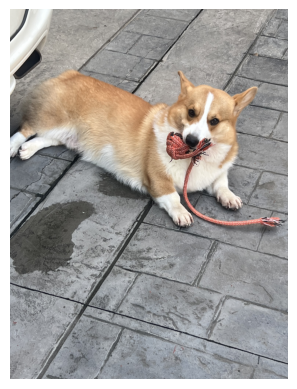

[('corgi', 'dataset/corgi/orl4sxvuncW5bsU5orV-o.jpg', 0.12064882497523066),
 ('corgi', 'dataset/corgi/lmrvqe2sr2rb1.jpg', 0.1345393159181434),
 ('corgi',
  'dataset/corgi/free-photo-of-close-up-of-a-corgi-lying-on-the-floor.jpeg',
  0.1612115521866433),
 ('corgi',
  'dataset/corgi/pembroke-welsh-corgi-900x900-crop-31-3-29-9.jpg',
  0.16153606084819383),
 ('corgi', 'dataset/corgi/dog-7578801_640.jpg', 0.16233380738880465)]

In [26]:
def search_similar_documents_with_image(conn, image, top_k=5):
    # Generate embedding for the query image
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        query_embedding = model.get_image_features(**inputs)
    query_embedding = query_embedding / query_embedding.norm(p=2, dim=-1, keepdim=True)  # normalize
    query_embedding_list = query_embedding.squeeze().tolist()

    # Create cursor for database operations
    cur = conn.cursor()
    sql = """
    SELECT class_name, path, 
           vec_cosine_distance(image_embedding, %s) AS distance
    FROM equipment_embeddings
    ORDER BY distance ASC
    LIMIT %s;
    """
    cur.execute(sql, (json.dumps(query_embedding_list), top_k))
    results = cur.fetchall()
    cur.close()

    return [(class_name, path, distance) for class_name, path, distance in results]

# Example usage
image = Image.open("testset/IMG_0794.jpg")
import matplotlib.pyplot as plt

# Display the image inline in the notebook
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# Perform the search
result = search_similar_documents_with_image(connection, image)
result